In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

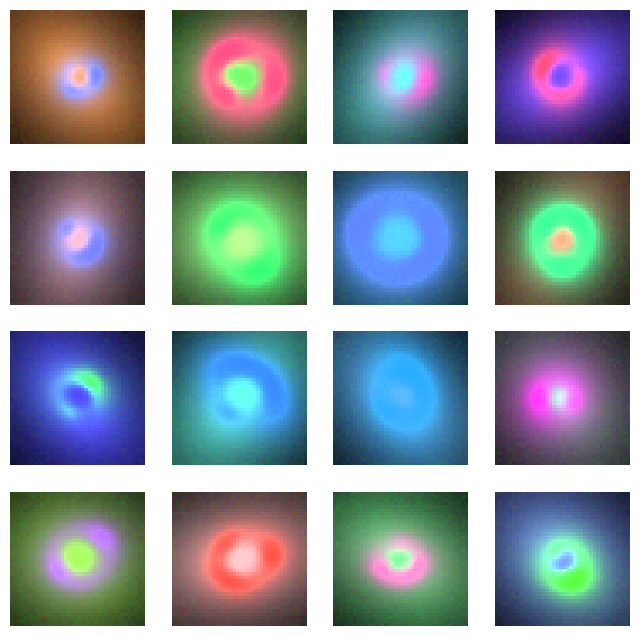

In [3]:
# Visualize source data
visualize_data(source_data)

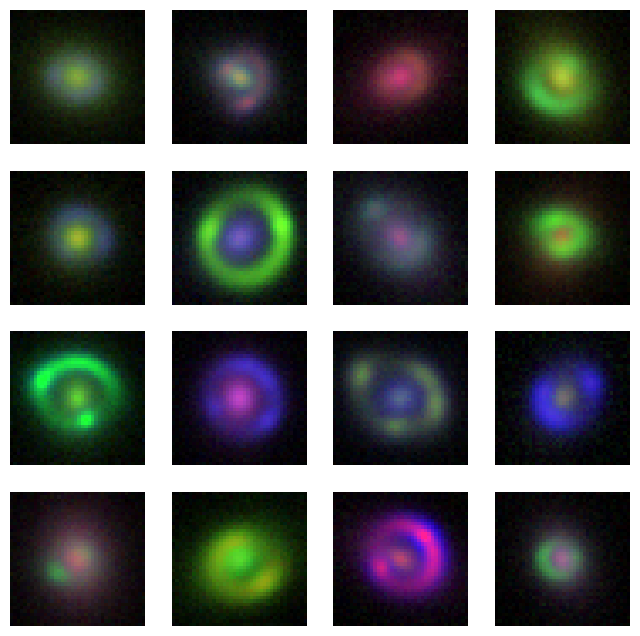

In [4]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [5]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return 0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5
n_epoch = 250
extra_epoch = n_epoch
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [6]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None #"models/mve_noDA_v1_aug7_0100" # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/mve_noDA_v1_aug7_1800"

## Train

Beginning Training...
Generating Isomap...


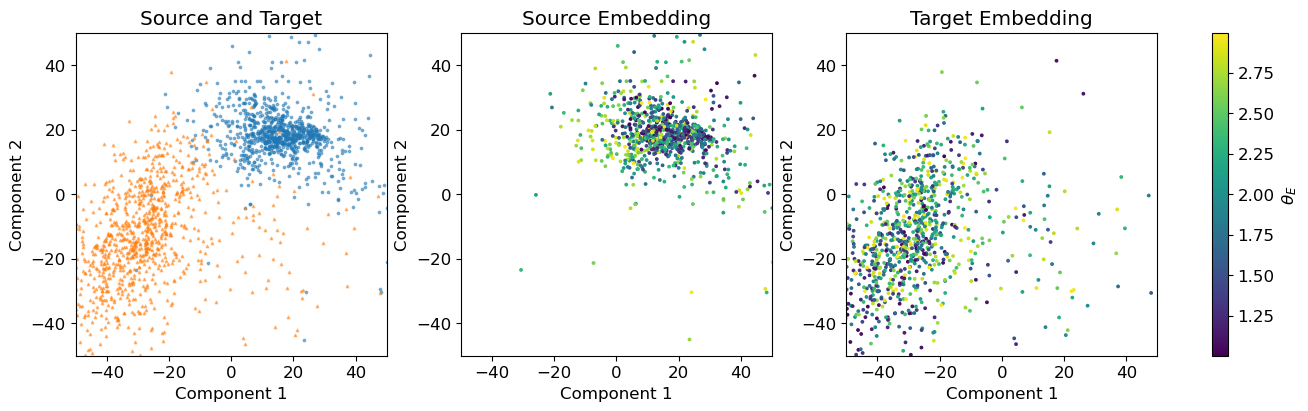


Epoch 0: 12.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4567
	Train Regression Loss: : 1.7798
	Train Mve Loss: : 0.7435
	Train R2 Score: : -4.4664
 Validation Statistics:
	Val Source Regression Loss: : 0.5365
	Val Target Regression Loss: : 0.5317
	Val Source R2 Score: : -0.6389
	Val Target R2 Score: : -0.6450
	Val Source Mve Loss: : 0.1288
	Val Target Mve Loss: : 0.1196
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 12.02s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4314
	Train Regression Loss: : 0.3326
	Train Mve Loss: : 0.0110
	Train R2 Score: : -0.0149
 Validation Statistics:
	Val Source Regression Loss: : 0.2610
	Val Target Regression Loss: : 0.2679
	Val Source R2 Score: : 0.1996
	Val Target R2 Score: : 0.1726
	Val Source Mve Loss: : -0.0419
	Val Target Mve Loss: : -0.0400
Saving Model... Done.
Saving Model MVE... Done.

Epoch 2: 9.78s
-------------------------------
 Training Statistics:
	Train Da Loss: : 

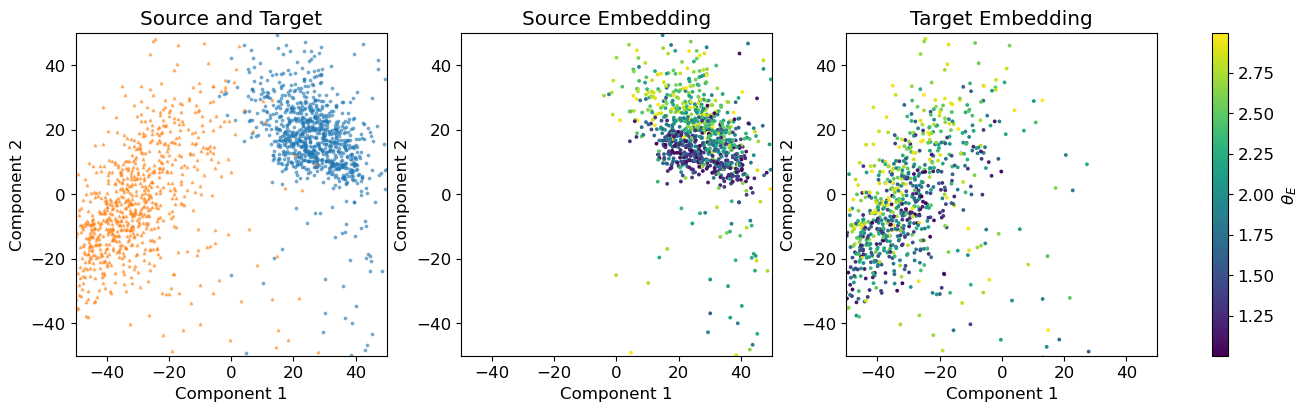


Epoch 20: 11.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5785
	Train Regression Loss: : 0.0243
	Train Mve Loss: : -0.1712
	Train R2 Score: : 0.9255
 Validation Statistics:
	Val Source Regression Loss: : 0.0252
	Val Target Regression Loss: : 0.0653
	Val Source R2 Score: : 0.9219
	Val Target R2 Score: : 0.7981
	Val Source Mve Loss: : -0.1728
	Val Target Mve Loss: : -0.1454

Epoch 21: 10.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5857
	Train Regression Loss: : 0.0247
	Train Mve Loss: : -0.1743
	Train R2 Score: : 0.9243
 Validation Statistics:
	Val Source Regression Loss: : 0.0249
	Val Target Regression Loss: : 0.0703
	Val Source R2 Score: : 0.9245
	Val Target R2 Score: : 0.7833
	Val Source Mve Loss: : -0.1728
	Val Target Mve Loss: : -0.1253

Epoch 22: 10.12s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5903
	Train Regression Loss: : 0.0244
	Train Mve Loss: : -0.1686
	Train R2 Score: : 0.9252

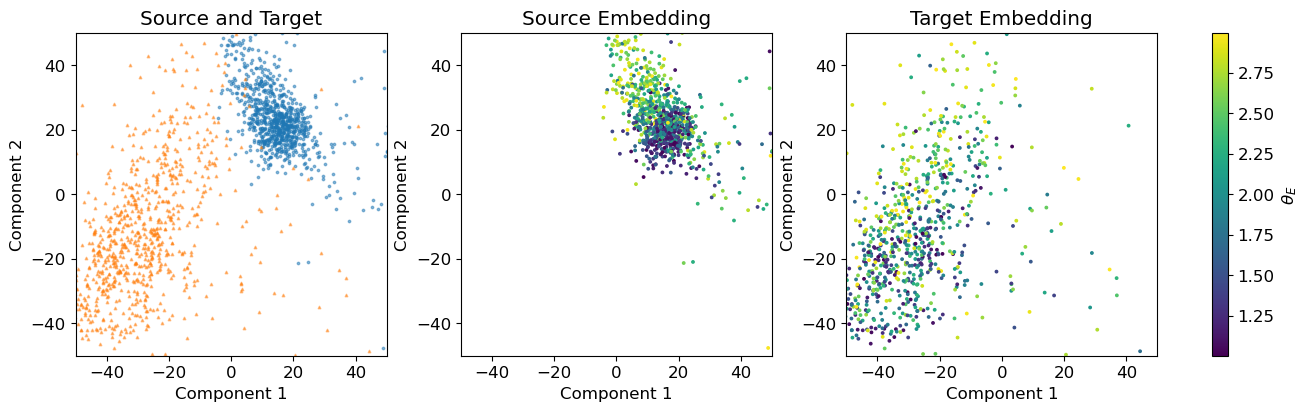


Epoch 40: 11.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.6937
	Train Regression Loss: : 0.0183
	Train Mve Loss: : -0.0760
	Train R2 Score: : 0.9439
 Validation Statistics:
	Val Source Regression Loss: : 0.0193
	Val Target Regression Loss: : 0.1016
	Val Source R2 Score: : 0.9412
	Val Target R2 Score: : 0.6644
	Val Source Mve Loss: : -0.1040
	Val Target Mve Loss: : 0.4289

Epoch 41: 12.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.6972
	Train Regression Loss: : 0.0178
	Train Mve Loss: : -0.0969
	Train R2 Score: : 0.9457
 Validation Statistics:
	Val Source Regression Loss: : 0.0189
	Val Target Regression Loss: : 0.0962
	Val Source R2 Score: : 0.9426
	Val Target R2 Score: : 0.7023
	Val Source Mve Loss: : -0.0614
	Val Target Mve Loss: : 0.5227

Epoch 42: 10.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.7042
	Train Regression Loss: : 0.0175
	Train Mve Loss: : -0.1208
	Train R2 Score: : 0.9462
 

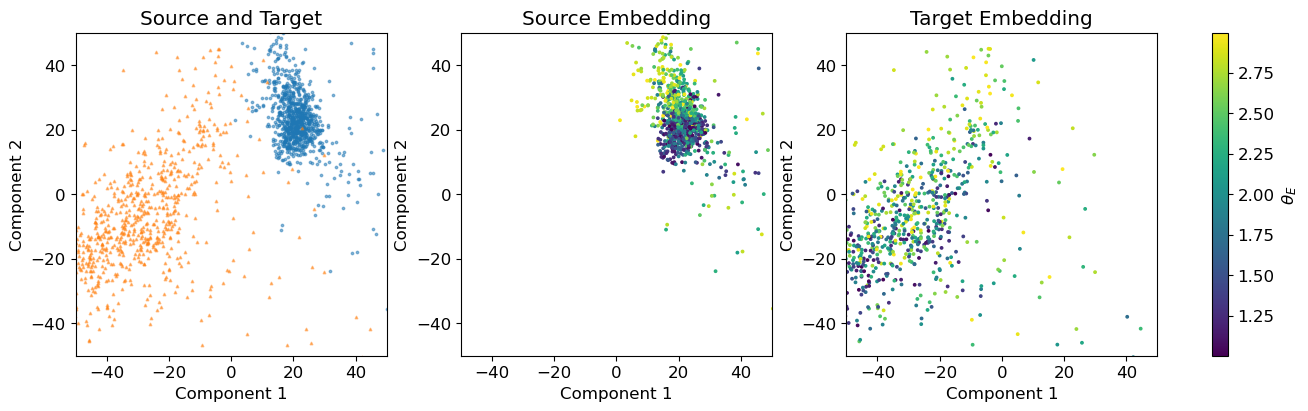


Epoch 60: 11.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.8298
	Train Regression Loss: : 0.0164
	Train Mve Loss: : -0.1358
	Train R2 Score: : 0.9497
 Validation Statistics:
	Val Source Regression Loss: : 0.0181
	Val Target Regression Loss: : 0.1390
	Val Source R2 Score: : 0.9453
	Val Target R2 Score: : 0.5687
	Val Source Mve Loss: : -0.0824
	Val Target Mve Loss: : 0.5142

Epoch 61: 10.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.8222
	Train Regression Loss: : 0.0162
	Train Mve Loss: : -0.1378
	Train R2 Score: : 0.9504
 Validation Statistics:
	Val Source Regression Loss: : 0.0174
	Val Target Regression Loss: : 0.1371
	Val Source R2 Score: : 0.9467
	Val Target R2 Score: : 0.5696
	Val Source Mve Loss: : -0.1683
	Val Target Mve Loss: : 0.1014

Epoch 62: 11.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.8226
	Train Regression Loss: : 0.0162
	Train Mve Loss: : -0.1605
	Train R2 Score: : 0.9504
 

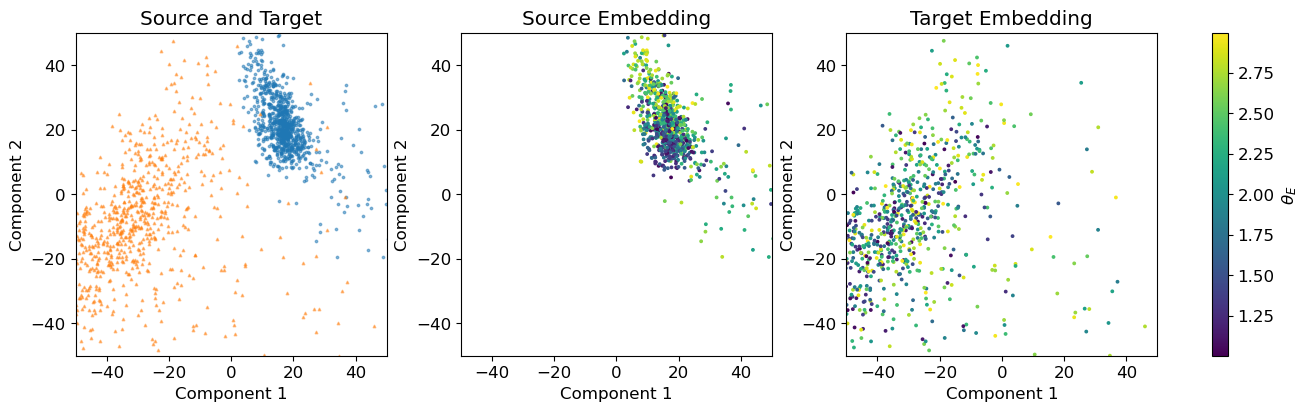


Epoch 80: 12.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.7308
	Train Regression Loss: : 0.0149
	Train Mve Loss: : -0.2238
	Train R2 Score: : 0.9543
 Validation Statistics:
	Val Source Regression Loss: : 0.0159
	Val Target Regression Loss: : 0.1211
	Val Source R2 Score: : 0.9518
	Val Target R2 Score: : 0.6195
	Val Source Mve Loss: : -0.1990
	Val Target Mve Loss: : 1.9457

Epoch 81: 12.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.7589
	Train Regression Loss: : 0.0147
	Train Mve Loss: : -0.2280
	Train R2 Score: : 0.9547
 Validation Statistics:
	Val Source Regression Loss: : 0.0161
	Val Target Regression Loss: : 0.1246
	Val Source R2 Score: : 0.9505
	Val Target R2 Score: : 0.6140
	Val Source Mve Loss: : -0.2341
	Val Target Mve Loss: : 2.3296

Epoch 82: 10.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.7662
	Train Regression Loss: : 0.0145
	Train Mve Loss: : -0.2197
	Train R2 Score: : 0.9554
 

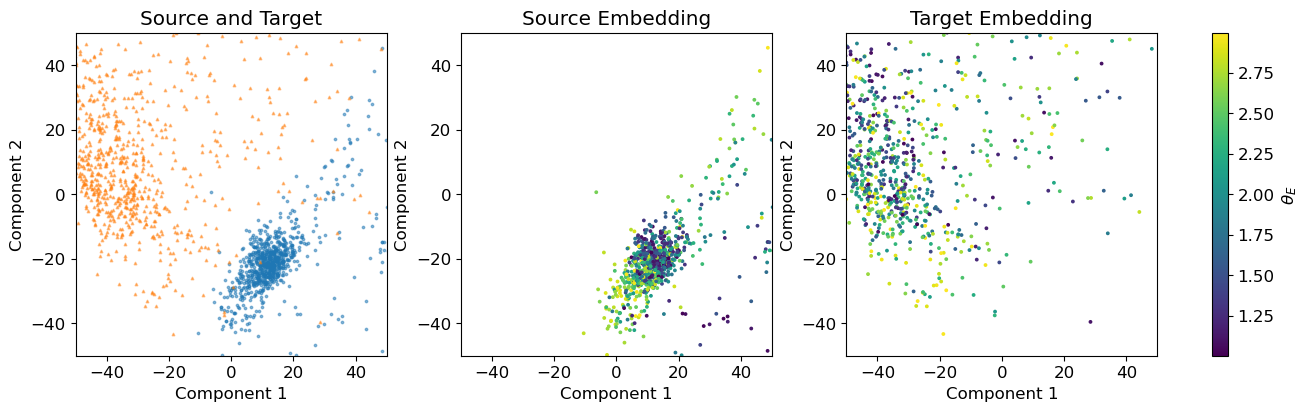


Epoch 100: 12.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.6345
	Train Regression Loss: : 0.0141
	Train Mve Loss: : -0.0463
	Train R2 Score: : 0.9568
 Validation Statistics:
	Val Source Regression Loss: : 0.0151
	Val Target Regression Loss: : 0.1364
	Val Source R2 Score: : 0.9541
	Val Target R2 Score: : 0.5697
	Val Source Mve Loss: : -0.2052
	Val Target Mve Loss: : 9.0468

Epoch 101: 12.49s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.6779
	Train Regression Loss: : 0.0138
	Train Mve Loss: : -0.0477
	Train R2 Score: : 0.9579
 Validation Statistics:
	Val Source Regression Loss: : 0.0143
	Val Target Regression Loss: : 0.1208
	Val Source R2 Score: : 0.9564
	Val Target R2 Score: : 0.6254
	Val Source Mve Loss: : -0.1586
	Val Target Mve Loss: : 12.2630

Epoch 102: 10.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.6998
	Train Regression Loss: : 0.0133
	Train Mve Loss: : -0.1491
	Train R2 Score: : 0.95

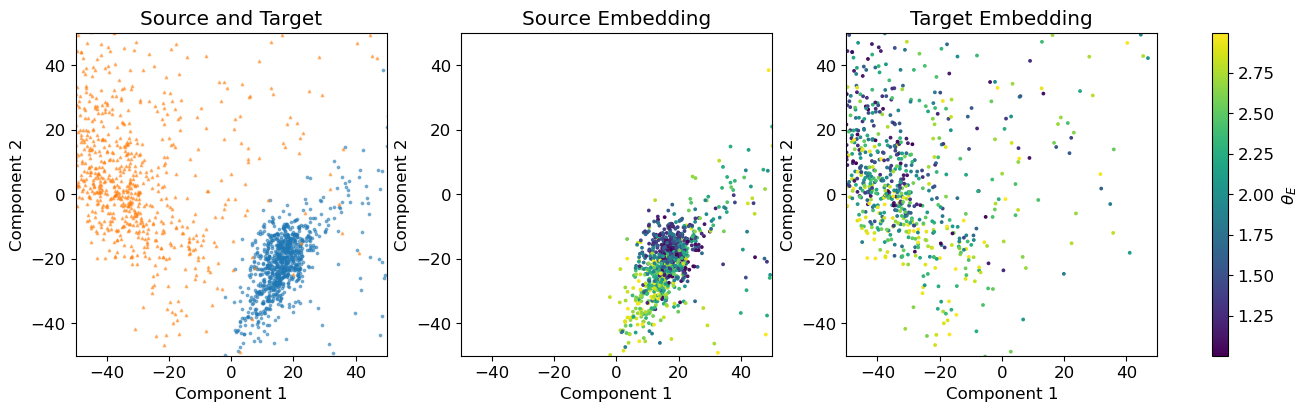


Epoch 120: 10.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.7018
	Train Regression Loss: : 0.0123
	Train Mve Loss: : -0.1961
	Train R2 Score: : 0.9622
 Validation Statistics:
	Val Source Regression Loss: : 0.0130
	Val Target Regression Loss: : 0.1142
	Val Source R2 Score: : 0.9602
	Val Target R2 Score: : 0.6457
	Val Source Mve Loss: : -0.2557
	Val Target Mve Loss: : 58.5872

Epoch 121: 10.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.7461
	Train Regression Loss: : 0.0124
	Train Mve Loss: : -0.1505
	Train R2 Score: : 0.9621
 Validation Statistics:
	Val Source Regression Loss: : 0.0143
	Val Target Regression Loss: : 0.1293
	Val Source R2 Score: : 0.9567
	Val Target R2 Score: : 0.5996
	Val Source Mve Loss: : -0.2579
	Val Target Mve Loss: : 27.4923

Epoch 122: 10.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.8043
	Train Regression Loss: : 0.0128
	Train Mve Loss: : -0.2968
	Train R2 Score: : 0.9

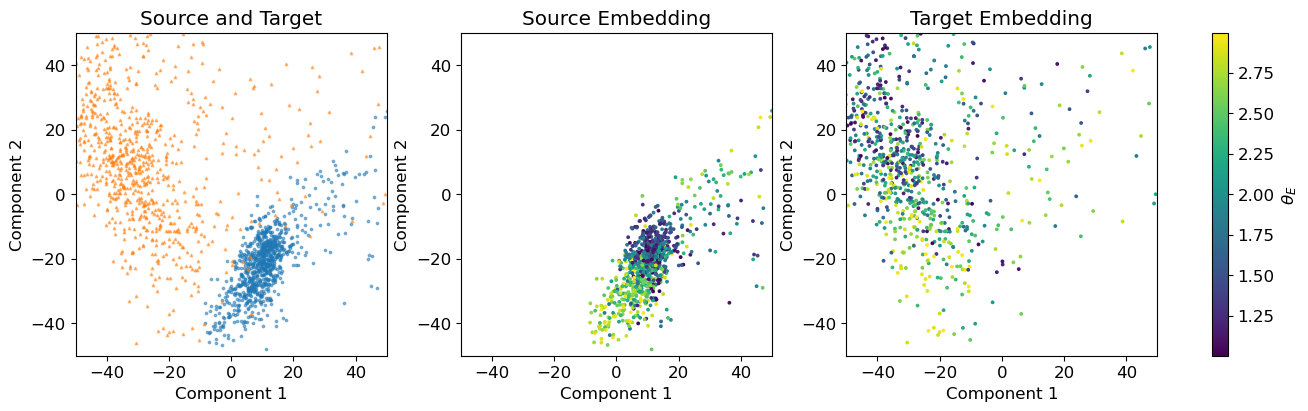


Epoch 140: 10.49s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5993
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.2646
	Train R2 Score: : 0.9626
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.0721
	Val Source R2 Score: : 0.9585
	Val Target R2 Score: : 0.7784
	Val Source Mve Loss: : 0.9587
	Val Target Mve Loss: : 90.7854

Epoch 141: 10.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5753
	Train Regression Loss: : 0.0115
	Train Mve Loss: : 0.1158
	Train R2 Score: : 0.9649
 Validation Statistics:
	Val Source Regression Loss: : 0.0131
	Val Target Regression Loss: : 0.0883
	Val Source R2 Score: : 0.9602
	Val Target R2 Score: : 0.7264
	Val Source Mve Loss: : -0.2721
	Val Target Mve Loss: : 17.0510

Epoch 142: 11.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.6197
	Train Regression Loss: : 0.0120
	Train Mve Loss: : -0.3191
	Train R2 Score: : 0.963

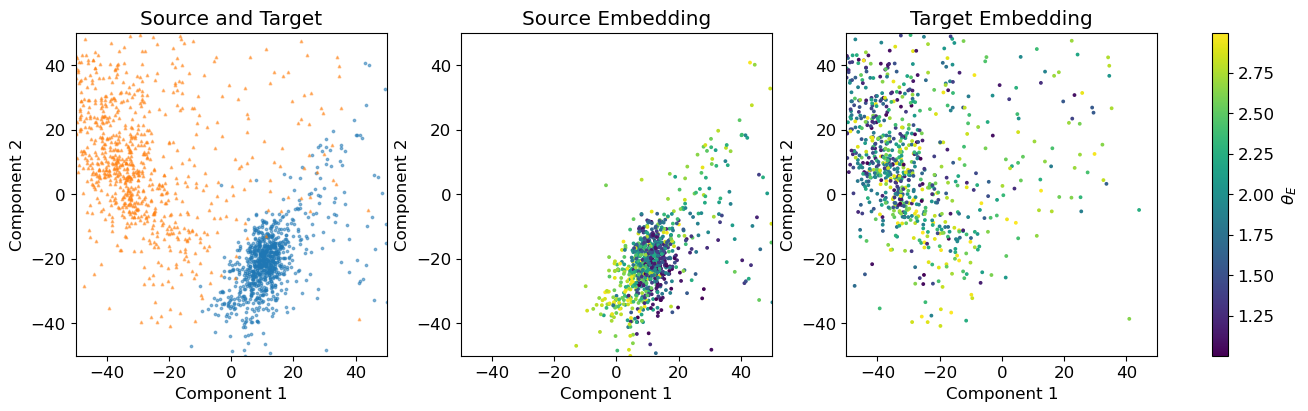


Epoch 160: 11.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5801
	Train Regression Loss: : 0.0120
	Train Mve Loss: : 0.3177
	Train R2 Score: : 0.9631
 Validation Statistics:
	Val Source Regression Loss: : 0.0120
	Val Target Regression Loss: : 0.0770
	Val Source R2 Score: : 0.9627
	Val Target R2 Score: : 0.7588
	Val Source Mve Loss: : 2.7935
	Val Target Mve Loss: : 370.1571

Epoch 161: 11.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5650
	Train Regression Loss: : 0.0119
	Train Mve Loss: : 0.8499
	Train R2 Score: : 0.9637
 Validation Statistics:
	Val Source Regression Loss: : 0.0125
	Val Target Regression Loss: : 0.0598
	Val Source R2 Score: : 0.9615
	Val Target R2 Score: : 0.8155
	Val Source Mve Loss: : 0.4136
	Val Target Mve Loss: : 95.1737

Epoch 162: 11.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5539
	Train Regression Loss: : 0.0114
	Train Mve Loss: : -0.3006
	Train R2 Score: : 0.9650

KeyboardInterrupt: 

In [8]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + extra_epoch):

        #Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [9]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [11]:
stat_tab = pd.DataFrame(stats)
stat_tab

,train_DA_loss,train_regression_loss,train_mve_loss,train_r2_score,val_source_regression_loss,val_target_regression_loss,val_source_r2_score,val_target_r2_score,val_source_mve_loss,val_target_mve_loss,da_weight,beta,epoch_no
0,0.456711,1.779818,0.743524,-4.466448,0.536534,0.531651,-0.638949,-0.645024,0.128819,0.119620,0,1.000,175
1,0.431371,0.332619,0.010964,-0.014915,0.260970,0.267894,0.199625,0.172566,-0.041867,-0.039954,0,0.996,175
2,0.432530,0.222419,-0.063484,0.322778,0.186422,0.201270,0.423693,0.379842,-0.074022,-0.061591,0,0.992,175
3,0.430713,0.145393,-0.075934,0.556669,0.109228,0.131121,0.668109,0.588093,-0.071393,-0.052017,0,0.988,175
4,0.432908,0.081295,-0.076198,0.751917,0.063640,0.083436,0.803073,0.737141,-0.084807,-0.085457,0,0.984,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.572201,0.013529,1.278070,0.958366,0.013664,0.056696,0.958675,0.823400,1.797967,683.228619,0,0.320,175
171,0.589835,0.012670,-0.195341,0.961072,0.013596,0.070483,0.958261,0.779162,2.573951,1269.451308,0,0.316,175
172,0.601269,0.012472,1.252188,0.961745,0.012800,0.064607,0.960631,0.800715,1.035452,644.410424,0,0.312,175
173,0.623953,0.011565,-0.309776,0.964461,0.012351,0.068451,0.961879,0.783250,1.832652,1052.234279,0,0.308,175


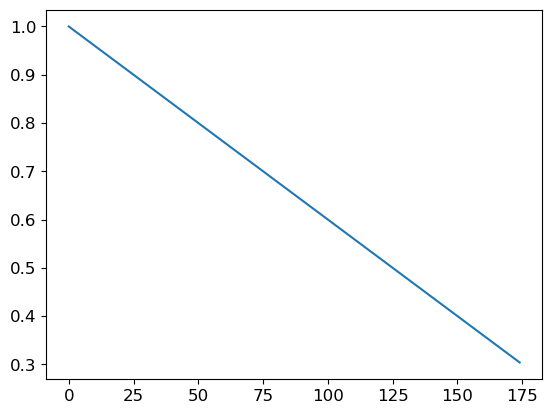

In [12]:
plt.plot(stat_tab['beta']) 

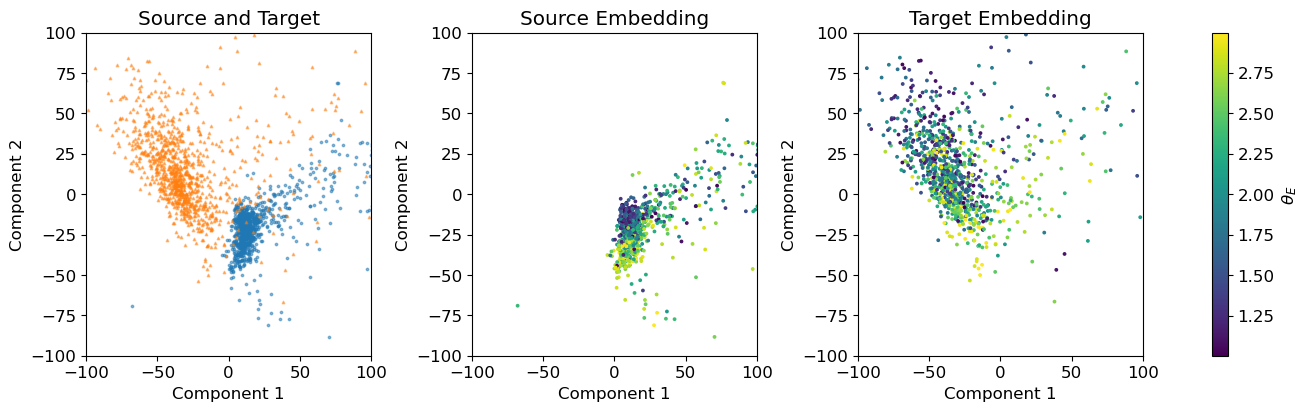

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [13]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 100)

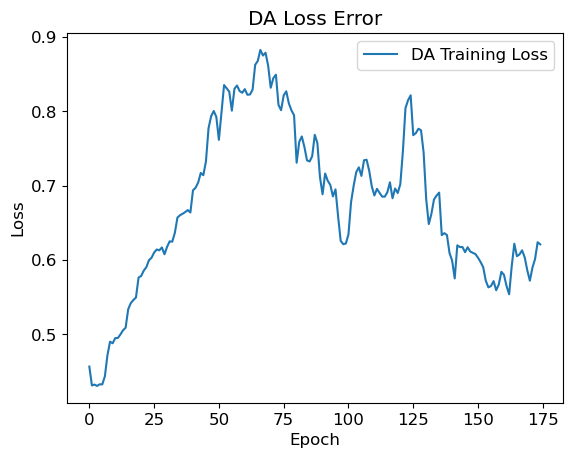

In [14]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

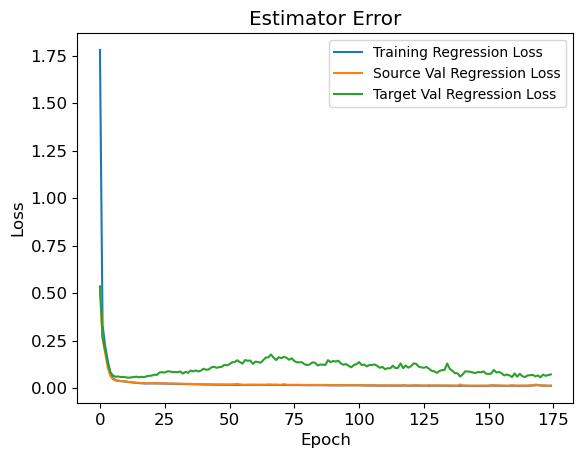

In [15]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

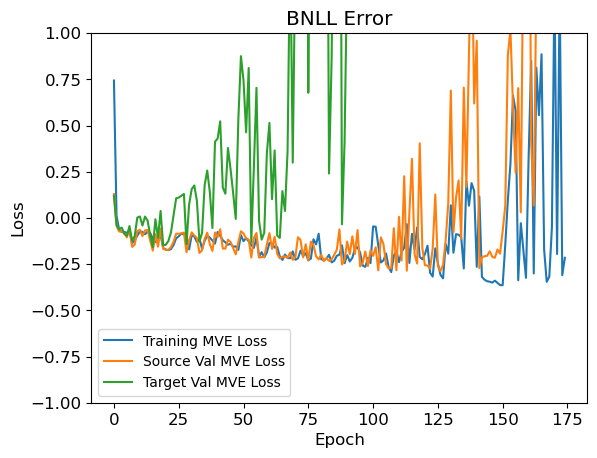

In [16]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

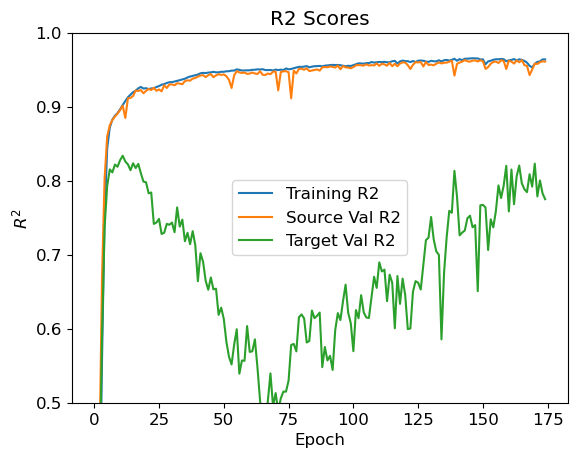

In [17]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [18]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9606


Text(0.5, 1.0, 'MMD | Source | R2: 0.961')

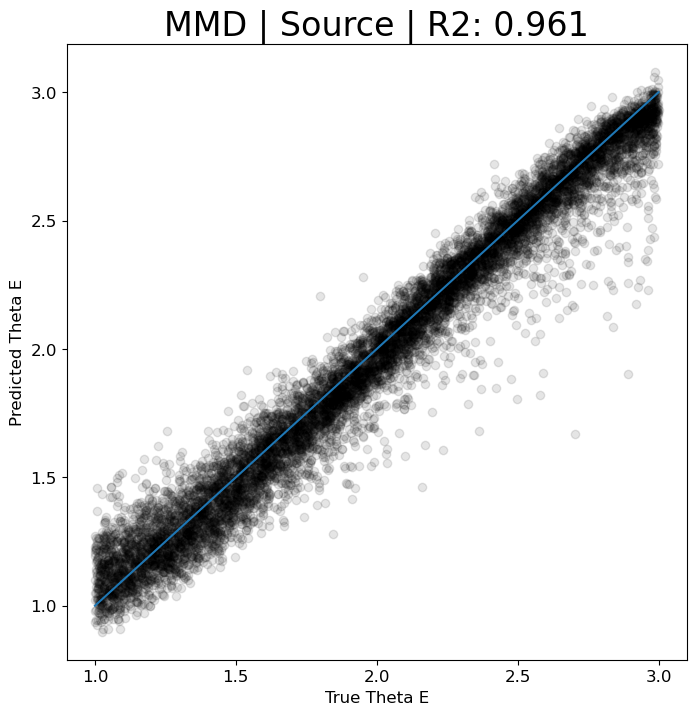

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.141')

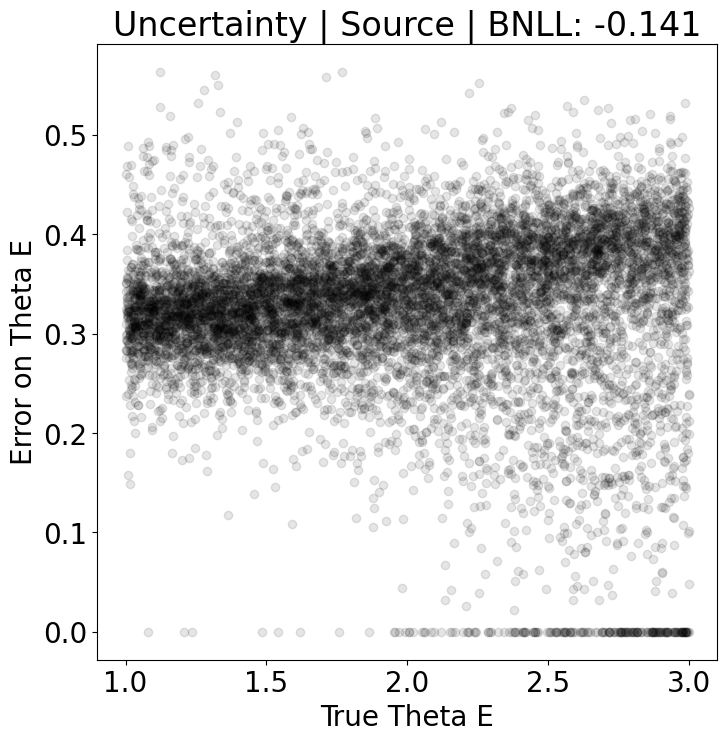

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [21]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.8182


Text(0.5, 1.0, 'MMD | Target | R2: 0.818')

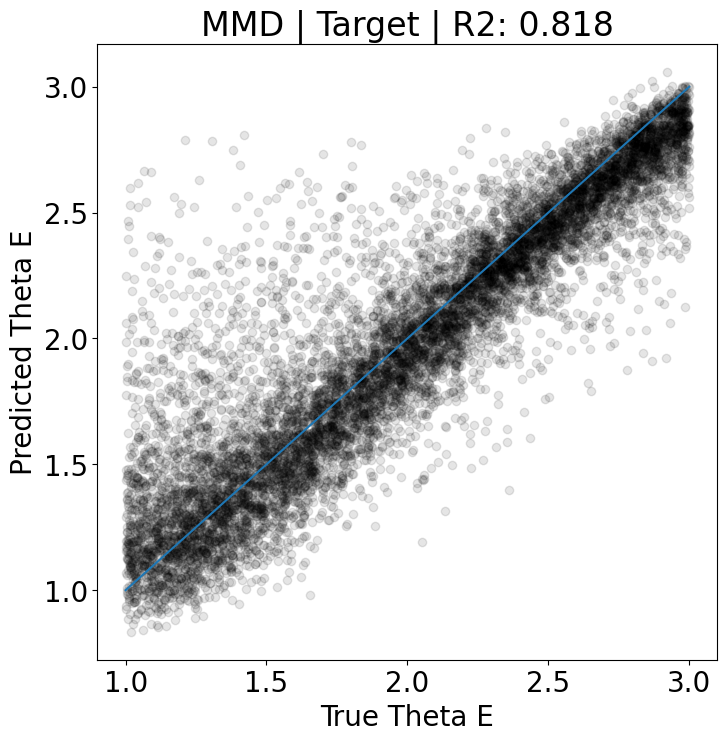

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.818')

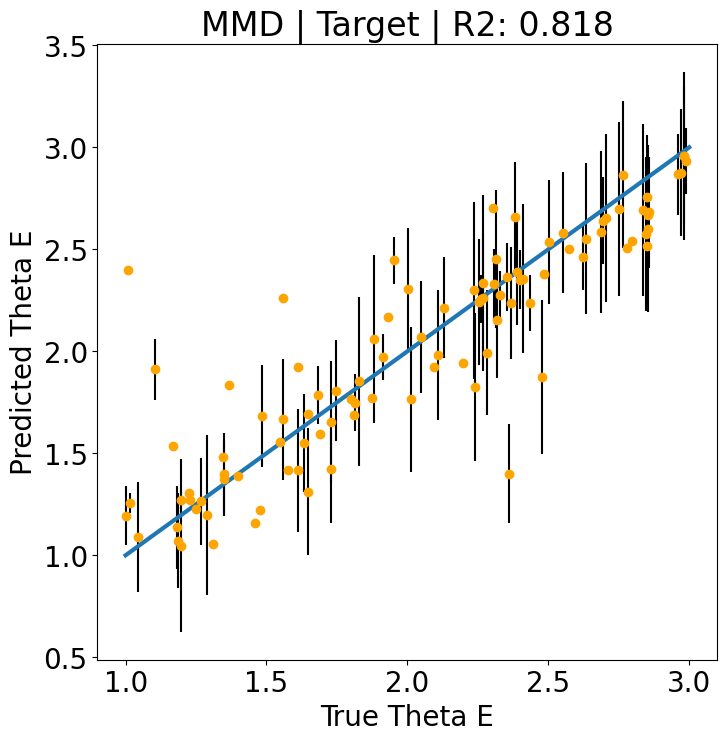

In [23]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: 59.520')

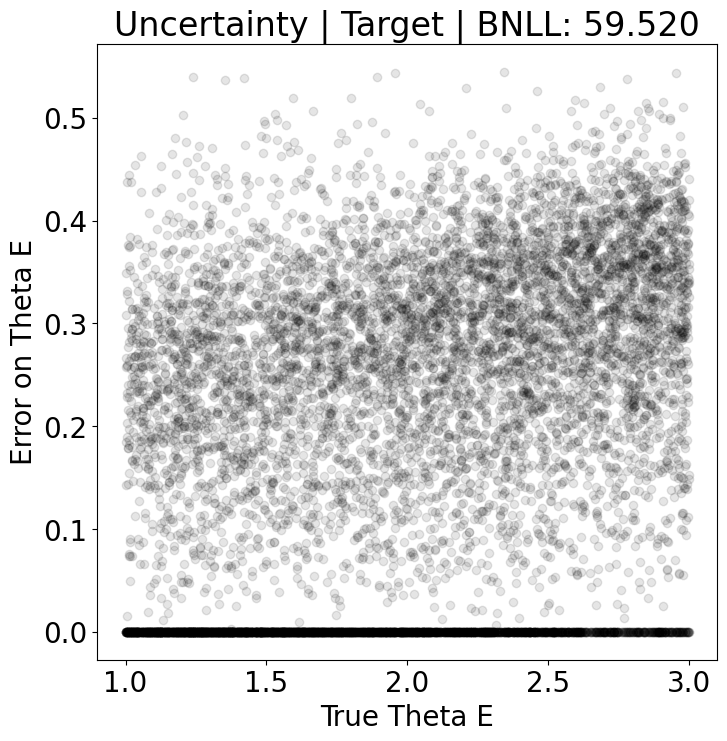

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [25]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

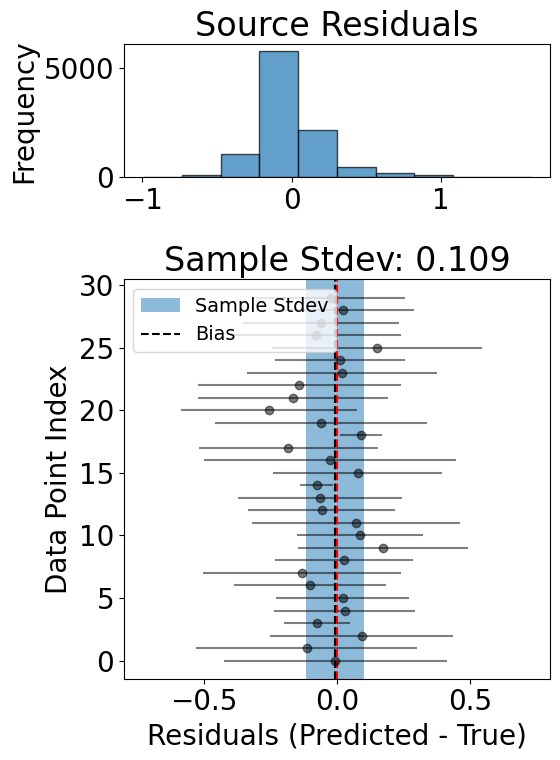

In [26]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

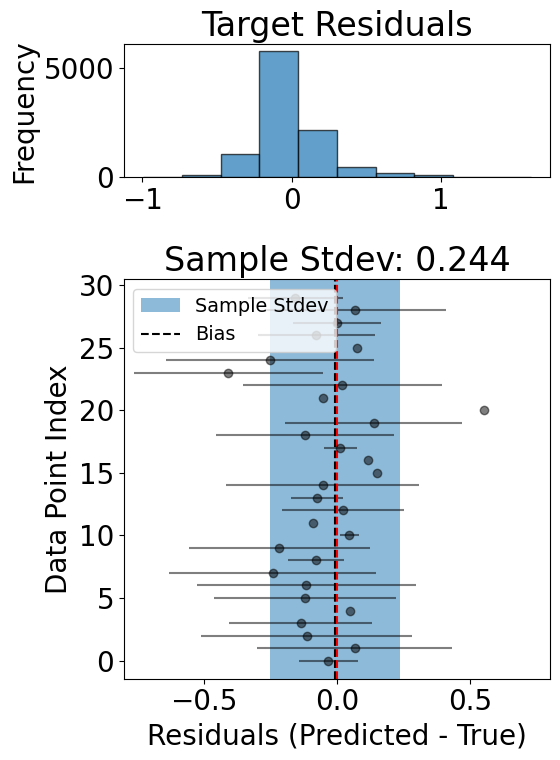

In [27]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()